In [2]:
SPEECH_FILE = "data/recordings/train/"

In [3]:
# Get the first file from directory
SPEECH_DEMO = SPEECH_FILE + random.choice(os.listdir(SPEECH_FILE))
IPython.display.Audio(SPEECH_DEMO, rate=16000)

In [4]:
if torch.backends.mps.is_available():
  device = 'mps'
elif torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

print(f"Using {device} device")

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print(f"Sample Rate: {bundle.sample_rate}")
print(f"Number of labels: {bundle.get_labels()}")
model = bundle.get_model().to(device)
print(model.__class__)

Using mps device
Sample Rate: 16000
Number of labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')
<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [5]:
sample_data, rate_sample_data = torchaudio.load(SPEECH_DEMO)
sample_data.shape

torch.Size([2, 200704])

In [6]:
from torchinfo import summary

summary(model, input_data=sample_data.to(device), col_names=['input_size', 'output_size', 'num_params', 'trainable'])

/Users/fbrynpk/anaconda3/envs/baymax_lite/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:25: UserWarning: The operator 'aten::_weight_norm_interface' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return _weight_norm(v, g, self.dim)


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
Wav2Vec2Model                                           [2, 200704]               [2, 626, 29]              --                        True
├─FeatureExtractor: 1-1                                 [2, 200704]               [2, 626, 512]             --                        True
│    └─ModuleList: 2-1                                  --                        --                        --                        True
│    │    └─ConvLayerBlock: 3-1                         [2, 1, 200704]            [2, 512, 40139]           6,144                     True
│    │    └─ConvLayerBlock: 3-2                         [2, 512, 40139]           [2, 512, 20069]           786,432                   True
│    │    └─ConvLayerBlock: 3-3                         [2, 512, 20069]           [2, 512, 10034]           786,432                   True
│    │    └─ConvLayerB

In [7]:
sample_data = sample_data.to(device)
model = model.to(device)
if rate_sample_data != bundle.sample_rate:
  sample_data = torchaudio.functional.resample(sample_data, rate_sample_data, bundle.sample_rate)

In [8]:
with torch.inference_mode():
  emission, _ = model(sample_data)

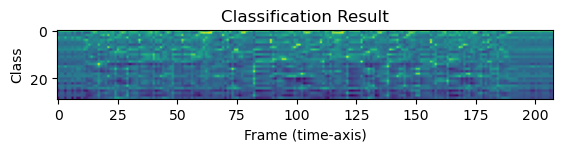

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [9]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification Result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [10]:
class GreedyCTCDecoder(nn.Module):
  def __init__(self, labels, blank=0):
    super().__init__()
    self.labels = labels
    self.blank = blank

  def forward(self, emission):
    """Given a sequence emission over labels, get the best path string
        Args:
        emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.
        Returns:
        str: The resulting transcript
    """
    indices = torch.argmax(emission, dim=1)
    indices = torch.unique_consecutive(indices, dim=-1)
    indices = [i for i in indices if i != self.blank]
    return "".join([self.labels[i] for i in indices])

In [11]:
decoder = GreedyCTCDecoder(bundle.get_labels(), blank=0)
transcript = decoder(emission[0])

In [16]:
print(transcript)
IPython.display.Audio(SPEECH_DEMO, rate=16000)

MISTARIHAR|EACH|FALLING|OUR|DUST|WHI|GOMBING|OU|


In [13]:
import pyaudio
import wave
import os

def record_audio(output_folder, filename, duration=5, sample_rate=44100, channels=1):
    audio = pyaudio.PyAudio()

    try:
        stream = audio.open(format=pyaudio.paInt16,
                            channels=channels,
                            rate=sample_rate,
                            input=True,
                            frames_per_buffer=1024)

        print("Recording...")

        frames = []
        for i in range(0, int(sample_rate / 1024 * duration)):
            data = stream.read(1024)
            frames.append(data)

        print("Finished recording.")

        stream.stop_stream()
        stream.close()

        audio.terminate()

        # Create the output folder if it doesn't exist
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Check if the file already exists, if yes, increment the index
        i = 0
        while True:
            output_filename = f"{filename}_{i}.wav"
            if not os.path.exists(os.path.join(output_folder, output_filename)):
                break
            i += 1

        # Save the audio to a WAV file with the new filename
        output_path = os.path.join(output_folder, output_filename)
        with wave.open(output_path, 'wb') as wf:
            wf.setnchannels(channels)
            wf.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
            wf.setframerate(sample_rate)
            wf.writeframes(b''.join(frames))

        print("Audio recorded and saved to", output_path)
    except Exception as e:
        print("An error occurred:", str(e))

if __name__ == "__main__":
    output_folder = "mic_records/"
    record_duration = 5  # seconds
    output_filename = "recorded_audio"

    record_audio(output_folder, output_filename, duration=record_duration)


Recording...
Finished recording.
Audio recorded and saved to mic_records/recorded_audio_9.wav


In [14]:
output_filename

'recorded_audio'

In [15]:
os.listdir(SAVE_PATH)

NameError: name 'SAVE_PATH' is not defined

# Steps

1. Record input
2. Process reply
3. Output reply

In [254]:
%%writefile record.py

import os
import pyaudio
import wave

def record_audio(duration=5, sample_rate=44100, channels=1):
    audio = pyaudio.PyAudio()

    try:
        stream = audio.open(format=pyaudio.paInt16,
                            channels=channels,
                            rate=sample_rate,
                            input=True,
                            frames_per_buffer=1024)

        print("Recording...")

        frames = []
        for i in range(0, int(sample_rate / 1024 * duration)):
            data = stream.read(1024)
            frames.append(data)

        print("Finished recording.")

        stream.stop_stream()
        stream.close()

        audio.terminate()

        # Create the output folder if it doesn't exist
        output_folder = "mic_records/"
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Check if the file already exists, if yes, increment the index
        i = 0
        while True:
            filename = "recorded_audio"
            output_filename = f"{filename}_{i}.wav"
            audio_path = os.path.join(output_folder, f"{output_filename}")
            if not os.path.exists(os.path.join(output_folder, output_filename)):
                break
            i += 1

        # Save the audio to a WAV file with the new filename
        output_path = os.path.join(output_folder, output_filename)
        with wave.open(output_path, 'wb') as wf:
            wf.setnchannels(channels)
            wf.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
            wf.setframerate(sample_rate)
            wf.writeframes(b''.join(frames))
    except Exception as e:
        print("An error occurred:", str(e))
    
    return audio_path

Writing record.py


In [255]:
%%writefile speech2text.py

import os
import torch
import torchaudio

from torch import nn
from record import record_audio

# Record audio as input file
input_audio = record_audio()

# Setup device agnostic code
if torch.backends.mps.is_available():
  device = 'mps'
elif torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

# Setup feature extractor model
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)

waveform, waveform_rate = torchaudio.load(input_audio)

waveform = waveform.to(device)
model = model.to(device)
if rate_sample_data != bundle.sample_rate:
  waveform = torchaudio.functional.resample(waveform, rate_sample_data, bundle.sample_rate)

with torch.inference_mode():
  emission, _ = model(waveform)
  
class GreedyCTCDecoder(nn.Module):
  def __init__(self, labels, blank=0):
    super().__init__()
    self.labels = labels
    self.blank = blank

  def forward(self, emission):
    """Given a sequence emission over labels, get the best path string
        Args:
        emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.
        Returns:
        str: The resulting transcript
    """
    indices = torch.argmax(emission, dim=1)
    indices = torch.unique_consecutive(indices, dim=-1)
    indices = [i for i in indices if i != self.blank]
    return "".join([self.labels[i] for i in indices])
  
decoder = GreedyCTCDecoder(bundle.get_labels(), blank=0)
transcript = decoder(emission[0])

print(transcript)

Writing speech2text.py
